# QR Code generator

This is a tool I created to challenge myself in coding. 

My goal was to create a "Hello world" QR Code from scratch. \
So in the current version, this generator only support QR code version 1 with the M error correction level. \
This is far from being the most efficient code, and I am opened for critiques if you have some. 

Perhaps I will update it in the future to support the other 39 version. 

Everything up to the Module placement phase was created only with functions baked in Python 3.12. \
I had to abandon this idea when I started to place the pixels for the final image. \
There was just no way I was doing matrix operations without numpy and scipy. \
The requirement for matplotlib is quite obvious. 

To build this project 2 website were extremly useful and completed each other in some aspects : 
- [Thonky.com](https://www.thonky.com/qr-code-tutorial/) has an amazing tutorial to understand the process and the math behind QR codes.
- [Project Nayuki](https://www.nayuki.io/page/creating-a-qr-code-step-by-step) has a QR code generator that explains all the step to get of the final product.


This project was structured is several phases :

- [Static values](#static-values)
- [Data analysis](#data-analysis)
- [Data encoding](#data-encoding)
- [Error correction coding](#error-correction-coding)
- [Setting up the data structure](#data-structure)
- [Module placement in matrix](#module-placement-in-matrix)
- [Data masking](#data-masking)
- [Final result](#final-result)

In [117]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d, convolve2d
from json import loads
import copy

## Static values

In this section, I just define some variables and functions that will be used later into the code

In [118]:
text = "Hello world!"


qr_code_infos = {
    "1-M" : {
        "Size": 21,
        "Total Number of Data Codewords for this Version and EC Level":16,
        "EC Codewords Per Block" : 10,
        "Number of Blocks in Group 1" : 1,
        "Number of Data Codewords in Each of Group 1's Blocks": 16,
        "Number of Blocks in Group 2": 0,
        "Number of Data Codewords in Each of Group 2's Blocks" : 0,
        "Number of bits for character count" : 8,
    }
}

encoding_modes =  {
    "bytes" : "0100"
}

format_information_strings = []
with open("format_information_strings.json", "r") as file:
    format_information_strings = loads(file.read())


In [119]:
def show_matrix(matrix, title:str = None):
    matrix_size = matrix.shape[0]
    fig = plt.figure()
    fig.suptitle(title)
    plt.imshow(matrix)

    ax = plt.gca()
    ax.set_xticks(np.arange(0, matrix_size, 1))
    ax.set_yticks(np.arange(0, matrix_size, 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, matrix_size, 1), minor=True)
    ax.set_yticks(np.arange(-.5, matrix_size, 1), minor=True)


    # Gridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

    # Remove minor ticks
    ax.tick_params(which='minor', bottom=False, left=False)


def show_final_result(matrix):
    matrix_size = matrix.shape[0]
    bigger_matrix = np.ones((matrix_size+6, matrix_size+6))
    bigger_matrix[3:matrix_size+3, 3:matrix_size+3] = matrix

    fig = plt.figure()
    plt.imshow(bigger_matrix)

## Data Analysis

Here, has this is a "Hello world" example, I decided myself on which version of QR code to use. \
I use QR code V1 (21x21). \
The text will be encoded with ISO-8859-1. \
The error correction level will be 15% (M)

Knowing all this info, the QR code will be able to handle 16 bytes of data.


In [120]:
version = "1-M"

number_of_data_bytes = qr_code_infos[version]["Total Number of Data Codewords for this Version and EC Level"]
number_of_bits_to_reach = number_of_data_bytes * 8
number_of_bits_for_character_count = qr_code_infos[version]["Number of bits for character count"]

mode_indicator = encoding_modes["bytes"] # mode indicator for bytes



# Data encoding

Now we encode the text, and create the full data phrase by adding the different parts : 
- The mode indicator (Mode = bytes in this instance)
- The number of characters
- The encoded text
- The data trailer
- The eventual padding in bit number % 8 <> 0
- And some more padding to fill the data bytes. 

In [121]:
print(mode_indicator, "- Mode Indicator")


# 1st step : encoding the character count
character_count = bin(len(text))[2:]
character_count = "0"*(number_of_bits_for_character_count-len(character_count)) + character_count
print(mode_indicator + character_count, "- Added Character Count")

# 2nd step : encoding the text

encoded_text = text.encode("iso-8859-1") 

phrase_binary = ""
for byte in encoded_text:
    letter_binary = bin(byte)[2:]
    letter_binary = "0"*(8-len(letter_binary)) + letter_binary
    phrase_binary += letter_binary

print(mode_indicator + character_count + phrase_binary, "- Added Binary phrase")

# 3rd step : adding the trailer

trailer = ""
if len(mode_indicator) + len(character_count) + len(phrase_binary) < number_of_bits_to_reach:
    trailer = ("0"*(number_of_bits_to_reach-len(phrase_binary)))[:4]

print(mode_indicator + character_count + phrase_binary + trailer, "- Added trailer")

# 4th step : Adding a padding of 0 if the length is not divisible by 8
zeros_padding = ""
while (len(mode_indicator) + len(character_count) + len(phrase_binary) + len(trailer) + len(zeros_padding)) % 8 != 0:
    zeros_padding += "0" 

print(mode_indicator + character_count + phrase_binary + trailer + zeros_padding, "- Added zeros padding")

# 5th step : if the length does not fill the full data bits, we add more padding  
allowed_padding_bytes = ["11101100", "00010001"]
padding_bytes = ""
alpha_exponent = 0
while len(mode_indicator) + len(character_count) + len(phrase_binary) + len(trailer) + len(zeros_padding) + len(padding_bytes) < number_of_bits_to_reach:
    padding_bytes += allowed_padding_bytes[alpha_exponent%2]
    alpha_exponent+=1

data_phrase = mode_indicator+character_count+phrase_binary + trailer + zeros_padding + padding_bytes

print(data_phrase, "- Added bytes padding")
print(len(data_phrase))



0100 - Mode Indicator
010000001100 - Added Character Count
010000001100010010000110010101101100011011000110111100100000011101110110111101110010011011000110010000100001 - Added Binary phrase
0100000011000100100001100101011011000110110001101111001000000111011101101111011100100110110001100100001000010000 - Added trailer
0100000011000100100001100101011011000110110001101111001000000111011101101111011100100110110001100100001000010000 - Added zeros padding
01000000110001001000011001010110110001101100011011110010000001110111011011110111001001101100011001000010000100001110110000010001 - Added bytes padding
128


## Error Correction Coding

The goal of this step is to create the error codes for our data bytes. 

The first step is to split the message codewords into groups

In [122]:
codewords = [data_phrase[i-8:i] for i in range(8, number_of_bits_to_reach+8, 8)]

group1 = []

number_of_blocks_group1 = qr_code_infos[version]["Number of Blocks in Group 1"]
number_of_codewords_in_block_group1 = qr_code_infos[version]["Number of Data Codewords in Each of Group 1\'s Blocks"]
for alpha_exponent in range(number_of_blocks_group1):
    block = codewords[alpha_exponent*number_of_codewords_in_block_group1:(alpha_exponent+1)*number_of_codewords_in_block_group1]
    group1.append(block)
    

group2 = []
group1_offset = number_of_blocks_group1 * number_of_codewords_in_block_group1

number_of_blocks_group2 = qr_code_infos[version]["Number of Blocks in Group 1"]
number_of_codewords_in_block_group2 = qr_code_infos[version]["Number of Data Codewords in Each of Group 1\'s Blocks"]
for alpha_exponent in range(number_of_blocks_group2):
    block = codewords[group1_offset+alpha_exponent*number_of_codewords_in_block_group2:group1_offset+(alpha_exponent+1)*number_of_codewords_in_block_group2]
    group2.append(block)


print(group1)
print(group2)


[['01000000', '11000100', '10000110', '01010110', '11000110', '11000110', '11110010', '00000111', '01110110', '11110111', '00100110', '11000110', '01000010', '00010000', '11101100', '00010001']]
[[]]


The second step is to generate the generator polynomial for our specific QR code version

---

Here, I'm just storing the antilog table for galoi fields (found [here](https://www.thonky.com/qr-code-tutorial/log-antilog-table) ).

So, in the Galois field:

2^0 = 1\
2^1 = 2\
...\
2^8 = 232\
2^9 = 205

For more info on how to generate this by hand, look [here](https://www.thonky.com/qr-code-tutorial/error-correction-coding#step-3-understand-the-galois-field) 

In [123]:
antilog_table = [1,2,4,8,16,32,64,128,29,58,116,232,205,135,19,38,76,152,45,90,180,117,234,201,143,3,6,12,24,48,96,192,157,39,78,156,37,74,148,53,106,212,181,119,238,193,159,35,70,140,5,10,20,40,80,160,93,186,105,210,185,111,222,161,95,190,97,194,153,47,94,188,101,202,137,15,30,60,120,240,253,231,211,187,107,214,177,127,254,225,223,163,91,182,113,226,217,175,67,134,17,34,68,136,13,26,52,104,208,189,103,206,129,31,62,124,248,237,199,147,59,118,236,197,151,51,102,204,133,23,46,92,184,109,218,169,79,158,33,66,132,21,42,84,168,77,154,41,82,164,85,170,73,146,57,114,228,213,183,115,230,209,191,99,198,145,63,126,252,229,215,179,123,246,241,255,227,219,171,75,150,49,98,196,149,55,110,220,165,87,174,65,130,25,50,100,200,141,7,14,28,56,112,224,221,167,83,166,81,162,89,178,121,242,249,239,195,155,43,86,172,69,138,9,18,36,72,144,61,122,244,245,247,243,251,235,203,139,11,22,44,88,176,125,250,233,207,131,27,54,108,216,173,71,142,1]


To do the necessary math with generator polynomial and the message polynomial, I represent them as lists in 2 different ways.

---

The first way is to represent the polynomial in a list where the index is he exponent of x  and the value is the coefficient.

For example the polynomial : \
5 * x^4 + 7 * x^3 + 0 * x^2 + 6 * x^1 + 2

Will be represented like this : \
[2, 6, 0, 7, 5]

---

The second way is when polynomial coefficients are represented as powers of 2 in the galois field. 

For example the polynomial : \
8 * x^4 + 16 * x^3 + 4 * x^2 + 32 * x^1 + 0

If we represent the coefficients as powers of 2 : \
2^3 * x^4 + 2^4 * x^3 + 2^2 * x^2 + 2^5 * x^1 + 0

This will be represented as : \
[null, 5, 2, 4, 3]


Then we just do the math discussed the guide.

In [124]:
number_of_ec = 7

def get_generator_polynomial(number_of_error_codewords):
    # Creating the generator polynomial
    generator_n = [0, 0] # Representation of the generator polynomial n. Equivalent to a^0*x^1-a^0*x^0 -> We take the exponent of a, and the exponent of x is symbolized by the position in the list

    for n in range(2, number_of_error_codewords+1):
        base = [n-1, 0] # Equivalent to a^0*x^1-a^1*x^0 -> We take the exponent of a, and the exponent of x is symbolized by the position in the list

        multiplication_of_x = generator_n.copy() 
        multiplication_of_x.insert(0, None)# .append(None) # As if we did a^0*x^1 (from the base) * (a^0*x^1-a^0*x^0) (from the generator n-1)

        multriplication_of_exponent = [i+base[0] for i in generator_n] 
        multriplication_of_exponent.append(0) # As if we did 

        generator_polynomial_n_plus_1 = []

        for n1, n2 in zip(multiplication_of_x,multriplication_of_exponent):
            if n1 is None : 
                generator_polynomial_n_plus_1.append(n2)
                continue
            value1 = antilog_table[n1%255]
            value2 = antilog_table[n2%255]

            result_xor = value1 ^ value2

            if result_xor == 0:
                generator_polynomial_n_plus_1.append(0)
            else : 
                exponent = antilog_table.index(result_xor)
                generator_polynomial_n_plus_1.append(exponent)

        generator_n = generator_polynomial_n_plus_1
    return generator_n

generator_polynomial_alpha=get_generator_polynomial(qr_code_infos[version]["EC Codewords Per Block"])



Then we generate the error codewords for each blocks 

In [125]:
def convert_from_alpha_to_numeric(poly_alpha: list[int]) -> list[int]:
    poly_num = []
    for alpha_exponent in poly_alpha:
        if alpha_exponent is None:
            poly_num.append(0)
        else: 
            poly_num.append(antilog_table[alpha_exponent])
    return poly_num

def convert_from_numeric_to_alpha(poly_num: list[int]) -> list[int]:
    poly_alpha = []
    for numerical_value in poly_num:
        if numerical_value == 0:
            poly_alpha.append(None)
        else:
            poly_alpha.append(antilog_table.index(numerical_value))
    return poly_alpha

def get_error_correction_codewords(message_code_words: list[str], generator_polynomial_alpha: list[int], number_of_error_codes_needed: int, number_of_codewords_in_block:int):
    # Converting the binary message codewords into numerical code words.
    # That gives us the message polynomial
    message_polynomial_numerical = []
    for binary in message_code_words:
        message_polynomial_numerical.append(int(binary,2))
    message_polynomial_numerical.reverse()


    # To get the right number of error codewords, we multiply the message polynomial by x^(number of error correction codewords that are needed)
    for _ in range(number_of_error_codes_needed):
        message_polynomial_numerical.insert(0, 0)

    result_previous_step_numeric = message_polynomial_numerical

    # Converting the message polynomial to aplha notation
    result_previous_step_alpha = convert_from_numeric_to_alpha(result_previous_step_numeric)


    for i in range(number_of_codewords_in_block):
        print("\nStep", i+1)
        # We make sure the generator polynomial has the exact same x exponent
        if len(result_previous_step_alpha) > len(generator_polynomial_alpha):
            generator_polynomial_alpha = [None] * (len(result_previous_step_alpha) - len(generator_polynomial_alpha)) + generator_polynomial_alpha
        elif len(result_previous_step_alpha) < len(generator_polynomial_alpha):
            generator_polynomial_alpha.pop(0)

        print("Generator polynomial (alpha)", generator_polynomial_alpha)
        print("Message polynomial (alpha)", result_previous_step_alpha)

        # We multiply the generator polynomial by the first exponent of the message polynomial
        multiplication_result_aplha = []
        for j in generator_polynomial_alpha:
            if j is None:
                multiplication_result_aplha.append(None)
            else:
                multiplication_result_aplha.append((j+result_previous_step_alpha[-1])%255)

        print("First multiplication (alpha)", multiplication_result_aplha)

        # We convert from alpha notation to numeric
        multiplication_result_numeric = convert_from_alpha_to_numeric(multiplication_result_aplha)

        # We XOR the message polynomial and the result from the previous sep
        result_previous_step_numeric = convert_from_alpha_to_numeric(result_previous_step_alpha)
        xor_numeric= []
        for n1, n2 in zip(result_previous_step_numeric, multiplication_result_numeric):
            xor_numeric.append(n1 ^ n2)


        # We remove the leading zeros
        for i in range(len(xor_numeric)-1, 0, -1):
            if xor_numeric[i] == 0:
                xor_numeric.pop(i)
            else:
                break

        print("XOR result (numeric)", xor_numeric)
        
        result_previous_step_alpha = convert_from_numeric_to_alpha(xor_numeric)

    error_correction_codewords = xor_numeric
    error_correction_codewords.reverse()
    return error_correction_codewords

error_code_words = get_error_correction_codewords(codewords, generator_polynomial_alpha, qr_code_infos[version]["EC Codewords Per Block"], qr_code_infos[version]["Number of Data Codewords in Each of Group 1's Blocks"])

print("Error codewords:", error_code_words)
error_code_words_binary = []

for ec in error_code_words:
    binary_word = bin(ec).replace("0b", '')
    byte = "0" * (8-len(binary_word)) + binary_word
    error_code_words_binary.append(byte)

print("Binary version:", error_code_words_binary)





Step 1
Generator polynomial (alpha) [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 45, 32, 94, 64, 70, 118, 61, 46, 67, 251, 0]
Message polynomial (alpha) [None, None, None, None, None, None, None, None, None, None, 100, 122, 4, 139, 164, 15, 232, 121, 198, 213, 164, 164, 219, 99, 183, 6]
First multiplication (alpha) [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 51, 38, 100, 70, 76, 124, 67, 52, 73, 2, 6]
XOR result (numeric) [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 236, 16, 66, 198, 44, 99, 103, 89, 236, 81, 4, 66, 76, 192]

Step 2
Generator polynomial (alpha) [None, None, None, None, None, None, None, None, None, None, None, None, None, None, 45, 32, 94, 64, 70, 118, 61, 46, 67, 251, 0]
Message polynomial (alpha) [None, None, None, None, None, None, None, None, None, None, 100, 122, 4, 139, 164, 240, 163, 110, 210, 122, 208, 2, 139, 16, 31]
First multiplication (alpha) [None, None, None, None, None, N

## Data structure

As this is a version 1 QR code, for the data structure, we just need to concatenate the data codewords with the binary codewords.

In [126]:
full_data_bytes = codewords + error_code_words_binary



## Module placement in matrix


### Adding finder patterns

In [127]:
matrix_size = qr_code_infos[version]["Size"]
matrix = np.ones((matrix_size, matrix_size), dtype=np.uint8)


def create_finder_pattern_at(matrix, x:int, y:int):
    matrix[y, x:x+7] = 0
    matrix[y:y+7, x] = 0
    matrix[y:y+7, x+6] = 0
    matrix[y+6, x:x+7] = 0

    matrix[y+2:y+5, x+2:x+5] = 0

    return matrix

matrix = create_finder_pattern_at(matrix, 0, 0)
matrix = create_finder_pattern_at(matrix, matrix_size-7, 0)
matrix = create_finder_pattern_at(matrix, 0, matrix_size-7)

show_matrix(matrix)

### Adding the timing patterns

In [128]:
def create_timing_patterns(matrix: np.ndarray):
    matrix_size = matrix.shape[0]
    matrix_copy = matrix.copy()
    matrix_copy[6,8:matrix_size-8] = [i%2 for i in range(matrix_size-16)]
    
    matrix_copy[8:matrix_size-8,6] = matrix_copy[6,8:matrix_size-8].T
    return matrix_copy

matrix = create_timing_patterns(matrix)

show_matrix(matrix)

### Adding alignement patterns 

(skipped because not needed for 1-M)

### Adding the Dark module and reserved areas

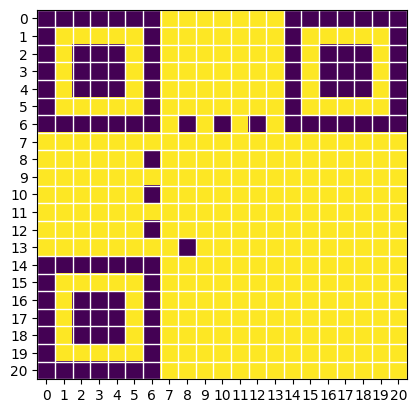

In [129]:
matrix[matrix_size-8, 8] = 0

reserved_areas_mask = np.ones_like(matrix, dtype=np.uint8)
reserved_areas_mask[0:9, 0:9] = 0
reserved_areas_mask[matrix_size-8:matrix_size, 0:9] = 0
reserved_areas_mask[0:9, matrix_size-8:matrix_size] = 0

reserved_areas_mask[:, 6] = 0
reserved_areas_mask[6, :] = 0
reserved_areas_mask[matrix_size-8, 8] = 0

show_matrix(matrix)

### Bit placement

To place all the bits, I split the QR code into 4 sections, and I treated them each individualy


<img src="images/QR_code_sections.png" alt="drawing" width="300"/>



In [130]:
full_phrase = "".join(full_data_bytes)
np_full_phrase = np.array(list(full_phrase)).astype(np.uint8)

[0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1]


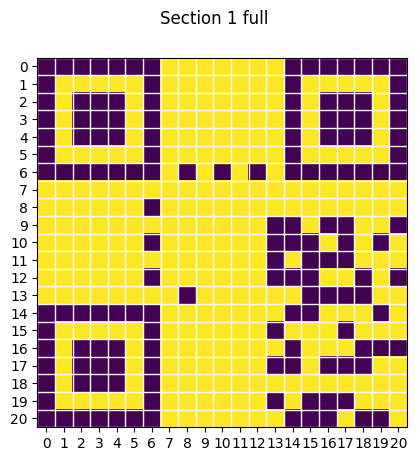

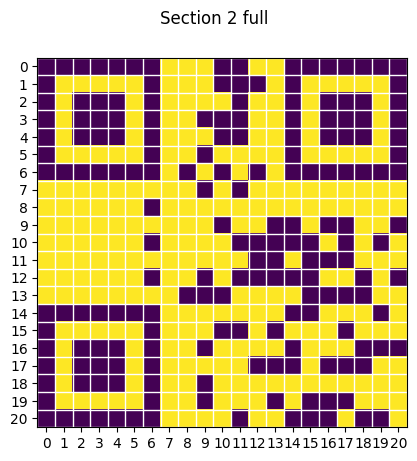

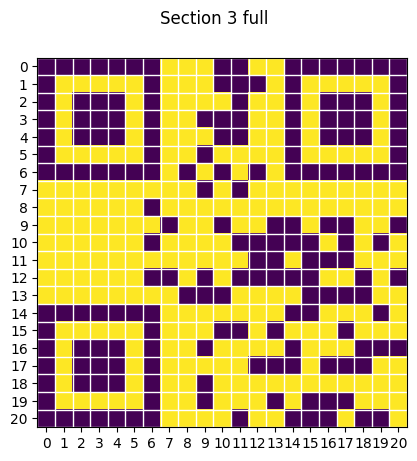

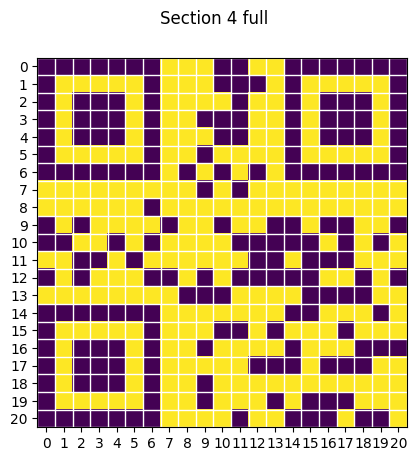

In [131]:
# Section 1

rows_for_section = matrix_size - 9
flipped_matrix = np.flip(matrix)
bytes = full_data_bytes.copy()
nb_bits_section1 = rows_for_section * 8
nb_writen_bits = 0

for c in range(4):
    descending_column = c % 2 != 0
    reversed_bits = ((np_full_phrase[c*rows_for_section*2:(c+1)*rows_for_section*2] + 1) % 2)
    if not descending_column :
        flipped_matrix[0:rows_for_section, c*2:(c+1)*2] = reversed_bits.reshape((rows_for_section, 2))
    else : 
        flipped_matrix[0:rows_for_section, c*2:(c+1)*2] = np.flip(reversed_bits.reshape((rows_for_section, 2)), 0)
    nb_writen_bits += len(reversed_bits)

show_matrix(matrix, "Section 1 full")
# Section 2

np_phrase_section2 = np_full_phrase[nb_writen_bits:]
rows_for_section = 20

for c in range(2):
    descending_column = c % 2 != 0

    rows_lower_section = matrix_size - 7
    rows_upper_section = 6

    reversed_bits = ((np_phrase_section2[c*rows_for_section*2:(c+1)*rows_for_section*2] + 1) % 2)

    bits_small_upper_section = rows_lower_section * 2

    if not descending_column :
        flipped_matrix[0:rows_lower_section, c*2+8:(c+1)*2+8] = reversed_bits[0:bits_small_upper_section].reshape((rows_lower_section, 2))
        flipped_matrix[rows_lower_section+1:rows_lower_section+1+rows_upper_section, c*2+8:(c+1)*2+8] = reversed_bits[bits_small_upper_section:].reshape((rows_upper_section, 2))

    else : 
        flipped_matrix[rows_lower_section+1:rows_lower_section+1+rows_upper_section, c*2+8:(c+1)*2+8] = np.flip(reversed_bits[0:12].reshape((rows_upper_section, 2)), 0)
        flipped_matrix[0:rows_lower_section, c*2+8:(c+1)*2+8] = np.flip(reversed_bits[12:].reshape((rows_lower_section, 2)), 0)

    nb_writen_bits += len(reversed_bits)

show_matrix(matrix, "Section 2 full")


# Section 3
# That's an ascending column - ALWAYS

np_phrase_section3 = np_full_phrase[nb_writen_bits:]
print(np_phrase_section3)

reversed_bits = ((np_phrase_section3[:(matrix_size-17)*2] + 1) % 2)

flipped_matrix[8:matrix_size-9, matrix_size-9 :matrix_size-7] = np.flip(reversed_bits.reshape((matrix_size-17,2)), 0)

nb_writen_bits += len(reversed_bits)

show_matrix(matrix, "Section 3 full")

# Section 4
# The first column is descending


np_phrase_section4 = np_full_phrase[nb_writen_bits:]
rows_for_section = matrix_size - 17

for c in range(3):
    reversed_bits = ((np_phrase_section4[c*rows_for_section*2:(c+1)*rows_for_section*2] + 1) % 2)
    descending_column = (c+1) % 2 != 0

    if not descending_column :
        flipped_matrix[8:8+rows_for_section, 15+c*2:15+(c+1)*2] = reversed_bits.reshape((rows_for_section, 2))
    else : 
        flipped_matrix[8:8+rows_for_section, 15+c*2:15+(c+1)*2] = np.flip(reversed_bits.reshape((rows_for_section, 2)), 0)

    nb_writen_bits += len(reversed_bits)

show_matrix(matrix, "Section 4 full")



## Data masking

It's time to apply masks

### Calculating the score

In [132]:
score = 0

# Rule 1 - Adding score point for every les of more than 5 same consecutive values.

def get_score_from_rule1(matrix):
    score = 0
    matrix_size = matrix.shape[0]
    for line in range(matrix_size):
        position = 0
        for _, iterations in itertools.groupby(matrix[line,:]):
            nb_iter = len(list(iterations))
            if nb_iter >= 5:
                score += 3 + nb_iter-5
            position += nb_iter

    for column in range(matrix_size):
        position = 0
        for _, iterations in itertools.groupby(matrix[:,column]):
            nb_iter = len(list(iterations))
            if nb_iter >= 5:
                score += 3 + nb_iter-5
            position += nb_iter
    return score

# Rule 2 - Adding 3 to the score for every squares of same values

def get_score_from_rule2(matrix):
    # Counting white squares
    nb_white_squares = np.count_nonzero(convolve2d(matrix,[[1,1],[1,1]], mode="same") == 4)

    # Counting black squares
    negative_matrix = (matrix+1)%2
    nb_black_squares = np.count_nonzero(convolve2d((negative_matrix+1)%2,[[1,1],[1,1]], mode="same") == 4)

    return (nb_white_squares + nb_black_squares)*3


# Rule 3 - Adding 40 to the score for each pattern found

def get_score_from_rule3(matrix):
    matrix_size = matrix.shape[0]
    pattern1_horizontal = np.array([1,1,1,1,0,1,0,0,0,1,0])
    pattern1_vertical = pattern1_horizontal.T

    pattern2_horizontal = np.array([0,1,0,0,0,1,0,1,1,1,1])
    pattern2_vertical = pattern2_horizontal.T

    nb_found_patterns = 0

    for row in range(matrix_size):
        for column in range(matrix_size-11):
            if np.all(matrix[row, column:column+11] == pattern1_horizontal) or np.all(matrix[row, column:column+11] == pattern2_horizontal):
                nb_found_patterns += 1

    for column in range(matrix_size):
        for row in range(matrix_size-11):
            if np.all(matrix[row:row+11, column] == pattern1_vertical) or np.all(matrix[row:row+11, column] == pattern2_vertical):
                nb_found_patterns += 1

    return nb_found_patterns * 40


# Rule 4 - Adding scores according to the ration of black and white squares

def get_score_from_rule4(matrix):
    negative_matrix = (matrix+1)%2
    matrix_size = matrix.shape[0]

    nb_black_pixels = np.count_nonzero(negative_matrix)
    percentage_black_pixels = 100 * (nb_black_pixels / (matrix_size*matrix_size))

    rest = percentage_black_pixels % 5
    previous_percentage = percentage_black_pixels - rest
    next_percentage = previous_percentage + 5

    next_percentage_absolute_difference = abs(next_percentage - 50)
    previous_percentage_absolute_difference = abs(previous_percentage - 50)

    nb_penality = min(next_percentage_absolute_difference/5, previous_percentage_absolute_difference/5) * 10

    return int(nb_penality) * 10

# Finale step 

def get_score(matrix):
    score = 0
    score += get_score_from_rule1(matrix)
    score += get_score_from_rule2(matrix)
    score += get_score_from_rule3(matrix)
    score += get_score_from_rule4(matrix)

    score += 4

    return score


### Adding the format patterns

To add the format pattenrs, I split the format pattern into 4 parts

<img src="images/image.png" alt="drawing" width="300"/>


In [133]:
def add_format_string(matrix: np.ndarray, version:str, mask):
    copy_matrix = matrix.copy()
    matrix_size = matrix.shape[0]
    format_string = []
    for value in format_information_strings:
        if value["ECC Level"] == version.split("-")[-1] and value["Mask Pattern"] == mask:
            format_string = value["Type Information Bits"].copy()
            break

    format_string_colors = ((np.array(format_string) + 1) % 2).tolist()

    reversed_format_string_colors = copy.deepcopy(format_string_colors)
    reversed_format_string_colors.reverse()

    # 1st
    copy_matrix[matrix_size-7:, 8] = reversed_format_string_colors[-7:]

    # 2nd
    copy_matrix[8,0:6] = format_string_colors[0:6]

    # 3rd
    copy_matrix[8,7:9] = format_string_colors[6:8]
    copy_matrix[7,8] = format_string_colors[8]

    # 4rth
    copy_matrix[0:6,8] = reversed_format_string_colors[:6]

    # 5th
    copy_matrix[8, matrix_size-8:] = format_string_colors[7:]
    return copy_matrix

### Applying masks

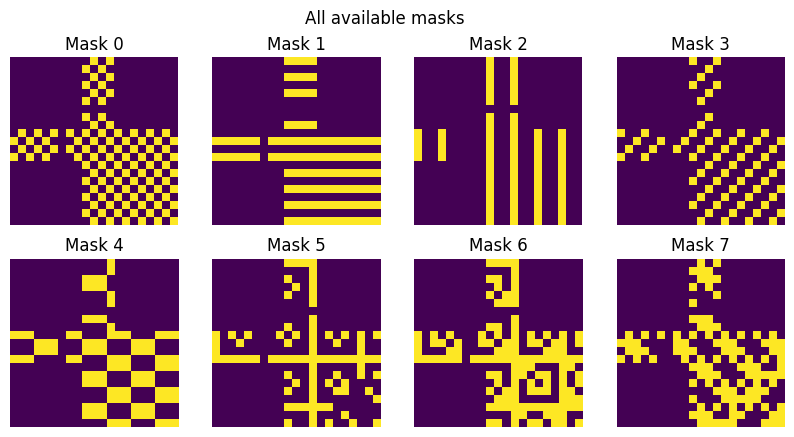

In [134]:
masks = [
    np.fromfunction(lambda row,column : (row+column)%2==0, (matrix_size, matrix_size), dtype=np.uint8),
    np.fromfunction(lambda row,column : row%2==0, (matrix_size, matrix_size), dtype=np.uint8),
    np.fromfunction(lambda row,column : column%3==0, (matrix_size, matrix_size), dtype=np.uint8),
    np.fromfunction(lambda row,column : (row + column)%3==0, (matrix_size, matrix_size), dtype=np.uint8),
    np.fromfunction(lambda row,column : (row // 2 + column // 3)%2==0, (matrix_size, matrix_size), dtype=np.uint8),
    np.fromfunction(lambda row,column : (row*column)%2 + (row*column)%3==0, (matrix_size, matrix_size), dtype=np.uint8),
    np.fromfunction(lambda row,column : ((row*column)%2 + (row*column)%3)%2==0, (matrix_size, matrix_size), dtype=np.uint8),
    np.fromfunction(lambda row,column : ((row+column)%2 + (row*column)%3)%2==0, (matrix_size, matrix_size), dtype=np.uint8),
]

fig, axs = plt.subplots(2,4)
fig.set_figwidth(10)
fig.suptitle("All available masks")
for row in range(2):
    for column in range(4):
        masks[row*4+column] = masks[row*4+column] & reserved_areas_mask
        axs[row, column].imshow(masks[row*4+column])
        axs[row, column].axis("off")
        axs[row, column].set_title(f"Mask {row*4+column}")


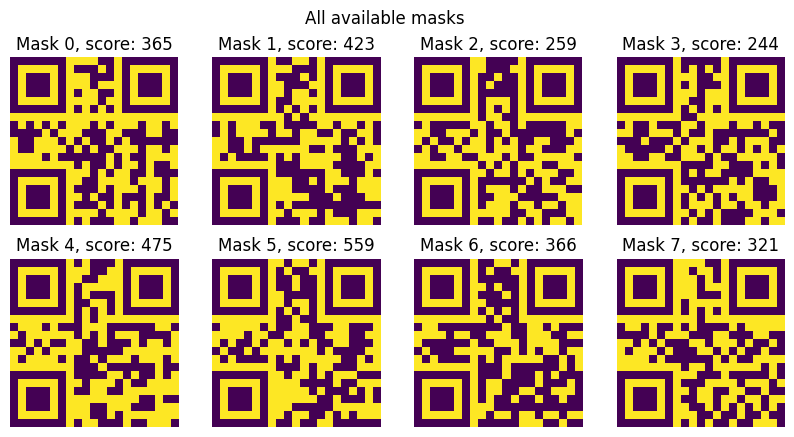

In [135]:
fig, axs = plt.subplots(2,4)
fig.suptitle("All available masks")
fig.set_figwidth(10)

matrices = []
scores = []

for row in range(2):
    for column in range(4):
        copy_matrix = matrix.copy()
        copy_matrix = copy_matrix ^ masks[row*4+column]

        copy_matrix = add_format_string(copy_matrix, version, row*4+column)

        score = get_score(copy_matrix)
        axs[row, column].imshow(copy_matrix)
        axs[row, column].axis('off')
        axs[row, column].set_title(f"Mask {row*4+column}, score: {score}")
        
        matrices.append(copy_matrix)
        scores.append(score)



Choice is mask 3


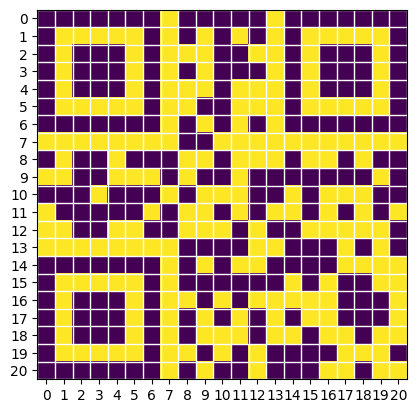

In [136]:
best_mask_index = np.argmin(scores)
matrix = matrices[best_mask_index]

print("Choice is mask", best_mask_index)

show_matrix(matrix)

## Final result

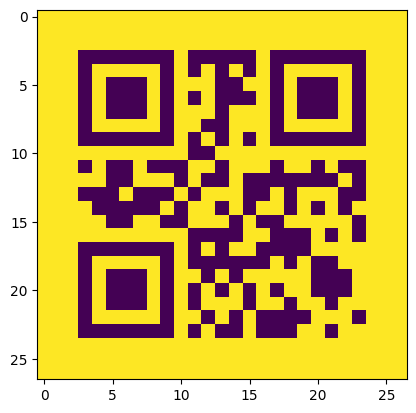

In [137]:
show_final_result(matrix)